In [31]:
# --------
# Imports
# --------
from math import pow # Convenience   
from Bio.Seq import Seq # Use Bio.Seq to translate() DNA sequences

import numpy as np 
import pandas as pd

import h5py # Only to handle .mat dataset

STOP_CODON = np.array([84, 65, 65, 84, 65, 71]) # T A A T A G
LINKER = Seq('KLNPPDESGEF') # Used within get_br()
LINKER_CODLEN = 11 # Used within get_br()

LINKER_NUCLEN = 33 # 3 * LINKER_CODLEN
RFP_NUCLEN = 828 # CALCULATED from len(NUC_RFP)
BFP_NUCLEN = 708


# Handling the .mat dataset
def load_matlab_file(mat_file, variable_name): # Note the double return statement
    
    
    """_summary_
    //UNIQUE: Only one variable for this .mat file
    
    Args:
        mat_file (string): Name of .mat file to intake (path must be given if not in current dir)
        variable_name (string): which variable from the mat file. Only one here because of the .mat file structure.

    Returns:
        h5py_object, data: Overall h5py_object and the specific variable as an nparray
    """
    h5py_object = h5py.File(mat_file, 'r')
    data = h5py_object.get(variable_name)
    data = np.array(data)
    return h5py_object, data

# For quick conversions from ndarray object to_...
def to_string(arr):
    string_seq = ""
    for i in arr:
        string_seq += chr(i)
    return string_seq
    
def to_seq(targ, string=False): 
    if string: # If it's already a string
        return Seq(targ)
    return Seq(to_string(targ))    

# Used in two DNA_SeqBlocks() funcs: get_br(), br_splitter()
def codon_to_nuc_idx(codon_idx, search_size): return (codon_idx+search_size)*3
def parsed_targ(targ):
    """Convert an np array of ord() DNA nucleotides with indels (45) to a string without indels. Also returns where the indels were.
    Args:
        targ (ndarray): get_target() function from DNA_SeqBlocks class
    Returns:
        cleaned_targ, indices_of_indels: Bio.Seq object without indels, nucleotide indices of where the indels were removed (maps to raw_targ)
    """
    indxs = (np.where(targ==45)[0]) # Dunno why they made it like this
    return Seq(to_string(targ).replace("-", "")), indxs
def rename(df, i, red=False, blue=False, transpose=False):
    if transpose == True: df = df.T
    cov = int(0.5*(df.columns.size-4))
    based_on_cov = ['target']
    based_on_cov.extend([f'read{i}' for i in range(1, cov+1)])
    based_on_cov.extend(x for x in [f'q{i}' for i in range(1, cov+1)])
    based_on_cov.extend(['changes', 'contig', 'mutations'])
    df.columns = based_on_cov
    if blue:
        df.index.name = f'B{i}'
    if red:
        df.index.name = f'R{i}'
    return df

# To house main dataset
class DNA_SeqBlocks():
    """Mat dataset 
    Loads the mat file with DNA sequences for easy iteration through all stored DNA sequence lists of varying coverage
    """
    
    def __init__(self, h5py_object, data):
        """Initialize DNA_SeqBlocks() object
        Args:
            h5py_object (h5py_object): first return variable of load_matlab_file
            data (np.array): second return variable of load_matlab_file
        """
        self.h5py_object = h5py_object
        self.data = np.transpose(data)
        self.size = len(data) 
        
    def get_seqblock(self, number, df=False): # Not really any reason to use this any longer 
        x = self.h5py_object[self.data[0, number-1]][:, :] # //UNIQUE: 0th column because .mat file, align3 variable only has one row
        if df:
            return x
        return np.transpose(x)
    
    def get_redsb(self, number, red_start, red_end, df=False): # Used within get_br()
        x = self.h5py_object[self.data[0, number-1]][red_start:red_end, :]
        if df:
            return x
        return np.transpose(x)
            
    def get_bluesb(self, number, blue_end, df=False): # Used within get_br()
        x = self.h5py_object[self.data[0, number-1]][:blue_end+1, :]
        if df:
            return x
        return np.tranpose(x)
    
    def get_target(self, number, end=-1): # Used within get_br()
        if end != -1:
            x = self.h5py_object[self.data[0, number-1]][:end, 0]
            return np.transpose(x)
        x = self.h5py_object[self.data[0, number-1]][:, 0]
        return np.transpose(x)
    
    def get_len(self, number):
        x = self.h5py_object[self.data[0,number-1]][:,0]
        return len(np.transpose(x))
    
    def get_coverage_count(self, number):
        """Coverage count

        Args:
            number (int): which sequence? matlab idx

        Returns:
            int: Number of reads
        """
        x = self.h5py_object[self.data[0, number-1]][0,:]
        coverage_count = int((len(x)-4)/2)
        return coverage_count
    
    def get_barcode_old(self, number): # Crucial. Garbage code but effective.
        """Barcode finder
        
        Changes that need to be made: use target sequence to find stop codon (reads may have mutated stop codon like 22776). Use read that doesn't terminate in indels to find the barcode.

        Args:
            number (int): which sequence? matlab indexing

        Returns:
            barcode, true_len: returns barcode uint16 ndarray, last matlab idx of stop codon
        """
        x = self.h5py_object[self.data[0, number-1]][:, 0] #assess with the targ
        r = self.h5py_object[self.data[0, number-1]][:, 1]
        barcode = 0 #tbr
        true_len = 0 #tbr
        total = x.size
        
        idx = total-1 #set to the end
        search_stop=True
    
        while idx >= 0 and search_stop: # CHANGED: This finds the stop codon if it has no indels
            
            if (x[idx] == 71): #Has to start with a G
                # Best Case Scenario
                if (x[idx-1] == 65):
                    if (x[idx-2] == 84):
                        if (x[idx-3] == 65):
                            if (x[idx-4] == 65):
                                if (x[idx-5] == 84):
                                    true_len = idx+1
                                    search_stop = False
                                    
                #                 elif x[idx-5] == 45: # What if T-AATAG?
                #                     if x[idx-6] == 84:
                #                         true_len = idx+1
                #                         search_stop = False
                                
                #             elif x[idx-4] == 45: # What if TA-ATAG?
                #                 if x[idx-5] == 65:
                #                     if x[idx-6] == 84:
                #                         true_len = idx+1
                #                         search_stop=False
                        
                #         elif x[idx-3] == 45: # What if TAA-TAG?
                #             if x[idx-4] == 65:
                #                 if x[idx-5] == 65:
                #                     if x[idx-6] == 84:
                #                         true_len = idx+1
                #                         search_stop = False
                    
                #     elif x[idx-2] == 45: # What if TAAT-AG?
                #         if x[idx-3] == 84:
                #             if x[idx-4] == 65:
                #                 if x[idx-5] == 65:
                #                     if x[idx-6] == 84:
                #                         true_len = idx+1
                #                         search_stop = False
                
                # elif (x[idx-1] == 45): # What if TAATA-G?
                #     if (x[idx-2] == 65):
                #         if x[idx-3] == 84:
                #             if x[idx-4] == 65:
                #                 if x[idx-5] == 65:
                #                     if x[idx-6] == 84:
                #                         true_len = idx+1
                #                         search_stop = False
    
            idx -= 1
        if true_len != 0:
            
            barcode = r[true_len:true_len+15] # Barcode is only the first 15 nucleotides anyway apparently
            
    
            if (barcode[-1] == 45 and barcode[-2] == 45): # only enters if the current barcode has two indels at the end
                list = [barcode]
                cov = self.get_coverage_count(number)
                if cov == 1: # no other option
                    if np.sum(barcode == 45) == 15:
                        return r[true_len+15:true_len+30], true_len # Only one case where this occurred (SB 236_645)
                    return barcode, true_len
            
                read_num = 2
                while (read_num <= cov):
                    barcode = self.h5py_object[self.data[0, number-1]][true_len:true_len+15, read_num]
                    if barcode[-1] == 45 and barcode[-2] == 45:
                        list.append(barcode)
                        read_num +=1
                    else: 
                        return barcode, true_len # if a better one is found
                
                # if they all have indels at the end
                
                bestindex = 0
                min_indel = 15
                for i in range(len(list)):
                    indel_freq = np.sum(list[i] == 45)
                    if (indel_freq) < min_indel:
                        min_indel = indel_freq
                        bestindex = i
                
                if min_indel == 15: # If the first 15 nucleotides are all indels. Special case scenario found at SB235_194
                    return r[true_len+15:true_len+30], true_len # Not really any reason to find the best. It's good enough to do this.
                return list[bestindex], true_len
                    
                
            return barcode, true_len
        return [],0
    
    def classify_stop(self, number):
        """Classify stop codon type or presence

        Args:
            number (_type_): _description_
        Returns:
            int: [0 == missing, 1 == clean, 2 == mutated]
        """
        targ = self.get_target(number)
        clean_targ, _ = parsed_targ(targ)
        
        if targ.find("TAATAG") != -1:
            return 1
        # This means it wasn't found
        if clean_targ.find("TAATAG") != -1:
            return 0 
        # This means there indeed is a indel_filled one
        return 2 # Further processing TBD to determine if its a true or fake mutation. //TODO
    
    def missing_stop(self, number): # Returns True if at least one read does not have a stop codon
        """Check for missing stop codon

        Args:
            number (no.): which sb?

        Returns:
            bool: True if stop codon is absent. Ignores indels.
        """
        clean_targ, _ = parsed_targ(self.get_target(number))
        
        if clean_targ.find("TAATAG") == -1: 
            return True
        return False # Can be fed into indel_stop to check for indel present in target

    def classify_indel_stop(self, number, run_missing=False): #// TODO: discriminate between a true mutation and a fake mutated stop
        """Check if stop codon has a potential mutation according to the reads. Not confirmed if a true or fake mutation

        Args:
            number (int): which sb?
            
        Returns:
            bool: True if mutation present
        """
        targ = self.get_target(number)
        indel_stop = True # only changes if the stop hasn't been confirmed to be clean or present yet
        
        if run_missing:
            if ~self.missing_stop(number): # if this returns False... meaning there is indeed a stop
                if targ.find("TAATAG") != -1: # Means a clean stop codon is not present...
                    # Confirms that there is an indel....
                    indel_stop = False
        if indel_stop:
            # Discriminate.  Now how do we decide if its a true indel stop or a fake one?
            pass
    
    def get_barcode(self, number): # Will find the stop codon mapping no matter what.
        targ, indels = parsed_targ(self.get_target(number)) # Removes all indels 
        idx = targ.find("TAATAG")
        
        if idx == -1:
            return [], 0
    
        idx += 6 # Gives true_len
        
        if len(indels) != 0:
            for n in indels: # To find the true index... You have to add +1 to the found nuc_idx (final_idx) if an indel was previously in the range...
                if n < idx:
                    idx +=1
        
        
        
        r = self.h5py_object[self.data[0, number-1]][:, 1]
        
        true_len = idx
        
        barcode = r[true_len:true_len+15] # Barcode is only the first 15 nucleotides anyway apparently
        
        if (barcode[-1] != 45 and barcode[-2] != 45):
            return barcode, true_len
        
        # only enters if the current barcode has two indels at the end
        list = [barcode]
        cov = self.get_coverage_count(number)
        if cov == 1: # no other option
            if np.sum(barcode == 45) == 15:
                return r[true_len+15:true_len+30], true_len # Only one case where this occurred (SB 236_645)
            return barcode, true_len
    
        read_num = 2
        while (read_num <= cov):
            barcode = self.h5py_object[self.data[0, number-1]][true_len:true_len+15, read_num]
            if barcode[-1] == 45 and barcode[-2] == 45:
                list.append(barcode)
                read_num +=1
            else: 
                return barcode, true_len # if a better one is found
        
        # if they all have indels at the end
        
        bestindex = 0
        min_indel = 15
        for i in range(len(list)):
            indel_freq = np.sum(list[i] == 45)
            if (indel_freq) < min_indel:
                min_indel = indel_freq
                bestindex = i
        
        if min_indel == 15: # If the first 15 nucleotides are all indels. Special case scenario found at SB235_194
            return r[true_len+15:true_len+30], true_len # Not really any reason to find the best. It's good enough to do this.
        return list[bestindex], true_len
            
    def get_nuc_qscores(self, number, nuc_pos, coverage_count=0): # Before pd.DF use
        if coverage_count == 0:
            cov = self.get_coverage_count(number)
            x = self.h5py_object[self.data[0, number-1]][nuc_pos-1, (1+cov):(1+2*cov)]
            return np.transpose(x)
        else:
            x = self.h5py_object[self.data[0, number-1]][nuc_pos-1, (1+coverage_count):(1+2*coverage_count)]
            return np.transpose(x)
    
    def get_nuc_reads(self, number, nuc_pos, coverage_count=0): # Before pd.DF use
        if coverage_count == 0:
            x = (self.h5py_object[self.data[0,number-1]][nuc_pos-1, 1:self.get_coverage_count(number)+1])
            return np.transpose(x)
        else: 
            x = self.h5py_object[self.data[0,number-1]][nuc_pos-1, 1:(coverage_count+1)]
            return np.transpose(x)
    
    def get_reads(self, number, coverage_count=0, true_len=0): # Before pd.DF use
        if coverage_count == 0 and true_len == 0:
            _, true = self.get_barcode(number)
            x = (self.h5py_object[self.data[0,number-1]][0:true, 1:self.get_coverage_count(number)+1])
            return np.transpose(x)
        else: 
            x = self.h5py_object[self.data[0,number-1]][0:true_len, 1:(coverage_count+1)]
            return np.transpose(x)
    
    def get_qscores(self, number, coverage_count=0, true_len=0): # Before pd.DF use
        if coverage_count == 0 and true_len == 0:
            _, true = self.get_barcode(number)
            cov = self.get_coverage_count(number)
            x = (self.h5py_object[self.data[0,number-1]][0:true, (1+cov):(1+2*cov)])
            return np.transpose(x)
        else: 
            x = self.h5py_object[self.data[0,number-1]][0:true_len, 1:(coverage_count+1)]
            return np.transpose(x)        
    
    def get_interp_changes(self, number, coverage_count=0, true_len=0):# Before pd.DF use
        if coverage_count == 0 and true_len == 0:
            _, true = self.get_barcode(number)
            x = self.h5py_object[self.data[0,number-1]][0:true,(1+2*self.get_coverage_count(number))]
            return np.transpose(x)
        else:
            x = self.h5py_object[self.data[0,number-1]][0:true_len,(1+2*coverage_count)]
            return np.transpose(x)
    
    def get_interp_mutations(self, number, coverage_count=0, true_len=0): # Before pd.DF use
        if coverage_count == 0 and true_len == 0:
            _,true=self.get_barcode(number)
            x = self.h5py_object[self.data[0,number-1]][0:true,(3+2*self.get_coverage_count(number))]
            return np.transpose(x)
        else:
            x = self.h5py_object[self.data[0,number-1]][0:true_len,(3+2*coverage_count)]     
            return np.transpose(x)      
    
    def get_interp_consensus(self, number, coverage_count=0, true_len=0): # Before pd.DF use
        if coverage_count == 0 and true_len == 0:
            _, true= self.get_barcode(number)
            x = self.h5py_object[self.data[0,number-1]][0:true,(2+2*self.get_coverage_count(number))]
            return np.transpose(x) 
        else:
            x = self.h5py_object[self.data[0,number-1]][0:true_len,(2+2*coverage_count)]
            return np.transpose(x) 

    def br_splitter(self, i): # Expects TRUELENS to be loaded
        """Get nucIDX where BFP terminates and nucIDX where RFP begins. Uses a match with protein sequence of linker 

        Args:
            i (int): sb no. (MATLAB) 
            Internal: Expects TRUELENS to be loaded

        Returns:
            2 indices: nuc_idx where bfp ends, nuc_idx where rfp begins
        """
        end = TRUELENS[i]
        if end == 0: # Stop is missing 
            raw_targ = (self.get_target(i)) # give it less to search by specifying an end
        else: 
            raw_targ = self.get_target(i, end=end)
        # raw_targ = self.get_target(i)
        
        targ, indel_coords = parsed_targ(raw_targ) # Removes indels, converts target into a Bio.Seq object
        
            
        p_targ = targ.translate()
        idx = p_targ.find(LINKER) # Looks for the linker... but what if it can't find one?
        
        # No FULL linker found
        if idx == -1: 
            size = len(targ)
            # Let's see if its obviously red...
            if TRUELENS[i] != 0 and size <= (RFP_NUCLEN + LINKER_NUCLEN): # If it has a stop codon... and its within the nuc_length of the RFP + linker it's RE
                # Red confirmed but let's remove any underlying linkage
                # Doesn't check for indels though ...
                ridx = targ.find("ATGGTG") # The first 6 aas of RFP
                if ridx == -1: # No beginning of red/linker but has STOP
                    return None, 0
                if len(indel_coords) != 0:
                    for n in indel_coords: # To find the true index... You have to add +1 to the found nuc_idx (final_idx) if an indel was previously in the range...
                        if n > ridx:
                            break
                        else:
                            ridx +=1
                return None, ridx
            
            # If it has NO STOP CODON... It's trickier
            # Could be blue_li, blu, (lu, ed)
            
            # First see if we can find the end of blue
            nuc_bfp_end = targ.find("AGATCT")

            # Can find blue_li, lue, ue, etc. But what if end is missing?
            if nuc_bfp_end != -1:
                nuc_bfp_end += 5 # Python index returned I believe...
                return nuc_bfp_end, None
            
            nuc_bfp_end = targ.find("ATCAGAGG") # Arbitrarily grabbed from middle of targ
            
            if nuc_bfp_end != -1:
                nuc_bfp_end += len("TCAGAGG")
                return nuc_bfp_end, None
            
            nuc_rfp_end = targ.find("AAGAAGA")
            
            if nuc_rfp_end != -1:
                nuc_rfp_end += len("AGAAGA")
                return None, nuc_rfp_end
            print(f"{i} is either a red partial or a blue partial that couldn't be foudn by nucs in the middle" )
            
            
                
        # Rare: Full linker at start of sequence. No blue.
        if idx == 0: 
            nuc_bfp_end = None # DNE
            nuc_rfp_beg = codon_to_nuc_idx( 0, search_size=LINKER_CODLEN)
            if len(indel_coords) != 0:
                for n in indel_coords:
                    if n <= nuc_rfp_beg:
                        nuc_rfp_beg += 1
            return None, nuc_rfp_beg
        
        # BEST CASE SCENARIO... Full linker Present
        codon_bfp_end = idx
        codon_rfp_beg = idx
        
        # Adjust based on indels
        nuc_bfp_end = codon_bfp_end*3-1
        nuc_rfp_beg = codon_to_nuc_idx( codon_rfp_beg, search_size=LINKER_CODLEN) # accounts for the + linker_codlen
    
        # for BFP -> shift RFP as well
        if len(indel_coords) != 0:
            for n in indel_coords: # To find the true index... You have to add +1 to the found nuc_idx (final_idx) if an indel was previously in the range...
                if n <= nuc_bfp_end:
                    nuc_bfp_end+=1
                    nuc_rfp_beg+=1
                elif n <= nuc_rfp_beg: # only gets here if its bigger than nuc_bfp_end   
                    nuc_rfp_beg+=1
        
        return nuc_bfp_end, nuc_rfp_beg

    def get_br(self, i): # Expects TRUELENS to be loaded
        """Gives the pd.DF objects that house the RFP and BFP for the specified ith seqblock

        Args:
            i (int): seqblock number

        Returns:
            BFP, RFP (pd.DataFrame): the parsed target with indices aligned to the target within the seqblock
        """
        b, r = self.br_splitter(i)
        if b == -1:
            return -1, -1
        red_end = TRUELENS[i]

        blue = pd.DataFrame(self.get_bluesb(i, blue_end=b, df=True))
        blue = rename(blue, i, blue=True)

        red = pd.DataFrame(self.get_redsb(i, red_start=r, red_end=red_end, df=True), index=np.arange(r, red_end))
        red = rename(red, i, red=True)

        return blue, red

# For conversions
def pscore(Qscore): 
    return pow(10, -(Qscore-33)/10)

# Deprecated functions
def seqblock_parser(seqblock): # Deprecated
    seqblock_parsed = CleanSeqBlock()
    total_columns = len(np.transpose(seqblock)) # is there a more efficient way?
    total_rows = len(seqblock)
    number_of_reads = int((total_rows - 4)/2) # last three rows have intreptations, first row is non-mutated target sequence, and N quality scores for N reads
    
    seqblock_parsed.cov = number_of_reads;
    seqblock_parsed.len = total_columns;
    
    # print(total_columns)
    # print(total_rows)
    tag = ""
    tag_length = 10_000
    
    for i in range(total_rows):
        # print(f" The sequenceblock input {seqblock}") #debug
        # print(f" The m x n size of the seqblock {seqblock.shape}") #debug
        # print(f" The ith row of the seqblock {current_seq}") #debug
        # print(f" The m x n size of the sequence {current_seq.shape}") #debug
        
        # new_format = np.chararray(total_columns) //CHANGED to string
        stop_found = False
        # new_format[:] = 'q' #debug
        
        # print(f" The 0th entry of the initialized char array {new_format[0, 0]}") #debug
        # print(f" Its row size {len(new_format[0])}")
        # if (i == 0):
        #     original = ""
        #     for j in range(total_columns):
        #         original += chr(seqblock[i,j])
                
                
        
        # if (i != 0):
  
        if (i == 0 or i == 1):
            new_format = ""
            j=0
        
            while j < total_columns:
                # print(j)
                                        
                if stop_found is False:
                    if (seqblock[i,j] == ord('T') and (j+6) < total_columns):
                        if (seqblock[i,j+1] == ord('A') and seqblock[i, j+2] == ord('A') and seqblock[i, j+3] == ord('T') and seqblock[i, j+4] == ord('A') and seqblock[i, j+5] == ord('G')):
                            new_format += 'T'
                            new_format += 'A'
                            new_format += 'A'
                            new_format += 'T'
                            new_format += 'G'
                            j = j+6
                            stop_found = True
                    if stop_found is False:
                        new_format += chr(seqblock[i,j])
                        j+=1
            
                elif stop_found is True and i == 1:
                    tag += chr(seqblock[i,j])
                    j+=1
                else:
                    j = total_columns
            if (i == 1): 
                seqblock_parsed.barcode = tag
                tag_length = len(tag)
        else:
            new_format = ""
            for j in range(total_columns-tag_length):
                new_format += chr(seqblock[i,j])
                
                
        if (i == 0):
            seqblock_parsed.target = new_format
        elif (i == total_rows - 1): # last row is mutations 'x', total_rows is one more than total index
            seqblock_parsed.interp_mutations = new_format
        elif (i == total_rows - 2): # 2nd last is subjective consensus
            seqblock_parsed.interp_consensus = new_format
        elif (i == total_rows - 3): 
            seqblock_parsed.interp_changes = new_format
        elif (i > 0 and i < number_of_reads + 1):
            seqblock_parsed.reads.append(new_format)
        else:
            seqblock_parsed.qscores.append(new_format)
    return seqblock_parsed     
class CleanSeqBlock(): # Deprecated
    def __init__(self):
        self.cov, self.len, self.target, self.interp_changes, self.interp_mutations, self.interp_consensus, self.barcode = 0,0,0,0,0,0,0
        self.reads, self.qscores = [], []


## Obtaining Data (O)

In [7]:
# Convert .mat dataset into a DNA_SeqBlocks object
file_name = 'consensus1.mat'
variable_of_interest = 'align3'
h5py_object, data = load_matlab_file(file_name, variable_name=variable_of_interest)

# DNA_seqs can be used to grab each raw_seqblock
DNA_seqs = DNA_SeqBlocks(h5py_object=h5py_object, data=data) 



In [8]:
# testing conventions
FILE_SIZE = DNA_seqs.size #Constant
tinyDS = range(10_000, 20_001)
DS = range(1, FILE_SIZE+1)


In [43]:
# Used for br_splitter() to randomly check 
middle = int(len(NUC_BFP)/2)
print(middle)
NUC_BFP[middle:]

middlered = int(len(NUC_RFP)/2)
print(middlered)
NUC_RFP[middlered:]

354
414


Seq('AAGAAGACAATGGGCTGGGAAGCGTCCACCGAGCGGTTGTACCCCGAGGACGGC...ATG')

In [4]:
# Load in barcodes and truelens for the day
import pickle
df = pickle.load(open('pickle/v2BarcodesTruelen.pickle', 'rb'))
BARCODES = df.barcode
TRUELENS = df.true_len
MISSING = TRUELENS[TRUELENS == 0].index # The seqblocks that definitely don't have to be included in a mutation library due to missing stop codons
# An actual CORRUPT where the stop codon is mutated will eventually be made


# CORRUPT = pickle.load(open('pickle/raw_corrupt_sb.pickle', 'rb')) # Use sequences in this list with caution...

In [9]:
from Bio.Seq import Seq
raw_bfp = Seq('atggtgagcgagctgattaaggagaacatgcacatgaagctgtacatggagggcaccgtggacaaccatcacttcaagtgcacatccgagggcgaaggcaagccctacgagggcacccagaccatgagaatcaaggtggtcgagggcggccctctccccttcgccttcgacatcctggctactagcttcctctacggcagcaagaccttcatcaaccacacccagggcatccccgacttcttcaagcagtccttccctgagggcttcacatgggagagagtcaccacatacgaagacgggggcgtgctgaccgctacccaggacaccagcctccaggacggctgcctcatctacaacgtcaagatcagaggggtgaacttcacatccaacggccctgtgatgcagaagaaaacactcggctgggaggccttcaccgagacgctgtaccccgctgacggcggcctggaaggcagaaacgacatggccctgaagctcgtgggcgggagccatctgatcgcaaacgccaagaccacatatagatccaagaaacccgctaagaacctcaagatgcctggcgtctactatgtggactacagactggaaagaatcaaggaggccaacaacgagacctacgtcgagcagcacgaggtggcagtggccagatactgcgacctccctagcaaactggggcacaagcttaattccggactcagatctcgagctcaagcttcgaattctgcagtcgacaaccctcctgatgagagtggccccggctgcatgagctgcaagtgtgtgctctcctga').upper()

In [22]:
len(NUC_BFP)

708

## Preload immutable aspects of dataset into pandas objects
- **Barcodes** and **truelens** of seqblock (excluding anything past stop codon)
- Ultimately, create a list of all seqblocks and store each seqblock in a pd.DataFrame

For later:
- //TODO: Find and clean the 7 repeat barcodes ?? could just be indels that need to be resolved to get uniqueness ??
- //TODO: Determine which stop codons are truly mutated and set their barcodes and truelens to [] and 0, respectively (ignore them)

#### BARCODES and TRUELENS generator 


In [80]:
# Generate list of BARCODES (associated by matlab index) and sequence length of focus 
# Passed tinyDS test. Concern now is separation of RFP from BFP

BARCODES = {}
TRUELENS = {}
for i in DS:
    bar, true = DNA_seqs.get_barcode(i)
    BARCODES.update({ i : bar })
    TRUELENS.update({ i : true })

x = pd.Series(BARCODES)
y = pd.Series(TRUELENS)

# Merge x and y into a single object
df = pd.DataFrame(x)
df[1] = y
df.columns = ['barcode', 'true_len']



7749      0
7966      0
8996      0
26751     0
34232     0
         ..
321903    0
321908    0
340855    0
346503    0
355011    0
Name: true_len, Length: 81, dtype: int64

In [86]:
# Store in pickle
import pickle
with open('pickle/v2BarcodesTruelen.pickle', 'xb') as f:
    pickle.dump(df, f)

In [ ]:
# BUGS with BARCODES and TRUELENS

check = y[y==0] # Used to index into barcodes
x[check.index] # 108 are empty... no barcode could be found

# There should be 354996 unique barcodes, but only 354889 are unique... => 7 repeats somewhere? Best to clean these 

In [ ]:
# Take a look at the 15-nuc barcodes that terminate with an indel 
bcodes = x.values.tolist()
indel_terminating_bcodes = []
for i in range(len(bcodes)): # note how it starts at 0
    curr = bcodes[i]
    
    if len(curr) != 0 and (curr[-1]) == 45:
        indel_terminating_bcodes.append(i+1)
print(indel_terminating_bcodes)

In [74]:
test = TRUELENS[1]
test

1482

#### Preload the Dataset into a list of DataFrames

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## Scrubbing Data (S)


#### Separating BFP (known) from RFP (mutations to be determined)

1. **Define** the target BFP sequence (understand our start differs from the online BFP) 
2. Figure out how to separate BFP from RFP using target... **Look up** how to deal with indels. There's got to be a better way 


raw_bfp retrieved from [addgene](https://www.addgene.org/browse/sequence/224756/)

In [6]:
from Bio.Seq import Seq
raw_bfp = Seq('atggtgagcgagctgattaaggagaacatgcacatgaagctgtacatggagggcaccgtggacaaccatcacttcaagtgcacatccgagggcgaaggcaagccctacgagggcacccagaccatgagaatcaaggtggtcgagggcggccctctccccttcgccttcgacatcctggctactagcttcctctacggcagcaagaccttcatcaaccacacccagggcatccccgacttcttcaagcagtccttccctgagggcttcacatgggagagagtcaccacatacgaagacgggggcgtgctgaccgctacccaggacaccagcctccaggacggctgcctcatctacaacgtcaagatcagaggggtgaacttcacatccaacggccctgtgatgcagaagaaaacactcggctgggaggccttcaccgagacgctgtaccccgctgacggcggcctggaaggcagaaacgacatggccctgaagctcgtgggcgggagccatctgatcgcaaacgccaagaccacatatagatccaagaaacccgctaagaacctcaagatgcctggcgtctactatgtggactacagactggaaagaatcaaggaggccaacaacgagacctacgtcgagcagcacgaggtggcagtggccagatactgcgacctccctagcaaactggggcacaagcttaattccggactcagatctcgagctcaagcttcgaattctgcagtcgacaaccctcctgatgagagtggccccggctgcatgagctgcaagtgtgtgctctcctga').upper()

Had to translate align3{1} target sequence (houses original, non-mutated) to find the domain linker, RFP, and BFP sequences

In [13]:
p_bfp = raw_bfp.translate()
parsed_true_bfp = p_bfp[3:] # Without the MVS
# MVS    EL -> used in the online head
# MVSKGE EL -> used as the head insetaed (modified)
true_bfp = parsed_true_bfp[:236] # Remove the linker and RFP part

# linker = Seq('KLNPPDESGEF')
# linker_codlen = len(linker) # The separator

# Copy and pasted from Expasy translate of align3{1} target seq. Only RFP part without linker or BFP
true_rfp = Seq('MVSKGEAVIKEFMRFKVHMEGSMNGHEFEIEGEGEGRPYEGTQTAKLKVTKGGPLPFSWDILSPQFMYGSRAFTKHPADIPDYYKQSFPEGFKWERVMNFEDGGAVTVTQDTSLEDGTLIYKVKLRGTNFPPDGPVMQKKTMGWEASTERLYPEDGVLKGDIKMALRLKDGGRYLADFKTTYKAKKPVQMPGAYNVDRKLDITSHNEDYTVVEQYERSEGRHSTGGMDELYK**KKKKKGSTGSR*LIIISHTTFVEVLLALKNLPHLPLNLKHKM')
# Reverse of last parts of BFP: SRLGSNLKHGLKSPLDCYRAVAVEH

In [16]:
# Get the raw nucleotides of bfp
nuc_bfp_search = raw_bfp[9:] # without the MVS 
end_codon = nuc_bfp_search.translate().find("GLRS")
last_nuc = codon_to_nuc_idx(end_codon, 4)
NUC_BFP = nuc_bfp_search[:last_nuc]

# Confirm results
NUC_BFP.translate() == true_bfp

True

In [17]:
# Get the actual nucleotdes of the linker
targ, _ = parsed_targ(DNA_seqs.get_target(1))
sidx= targ.find(NUC_BFP)
eidx = sidx + len(NUC_BFP)

mix = targ[eidx:] #Now has the nucleotides of linker prefixed to rfp

NUC_LINKER = mix[:3*LINKER_CODLEN]
print(len(NUC_LINKER)%3)
NUC_RFP = mix[3*LINKER_CODLEN:-1]
print(len(NUC_RFP)%3)
NUC_LINKER.translate() == LINKER, NUC_RFP.translate() == true_rfp # Returns True

0
0


(True, True)

In [12]:
# Test of finding first MVSKGE
test = Seq(to_string(DNA_seqs.get_target(1)))
temp = test.translate().find("MVSKGE") #6 codons
(temp+6)*3 # Find the index of the codon that is outside the target group. Multiply by 3 to get the nucleotide-mirrored index
test[0:39].translate()

/home/neurotoolbox/.virtualenvs/venv/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


Seq('LALPVATMVSKGE')

## Splitting based on LINKER between RFP and BFP

- Indels have to be removed in target. But we still need to keep track of 1) where they were removed 2) whether the index falls within the indices of the indels...

Original idea: Use start of BFP (MVSKGEEL) but Yiyang told me about the linker 

In [25]:
def codon_to_nuc_idx(codon_idx, search_size): return (codon_idx+search_size)*3
def parsed_targ(targ):
    """Convert an np array of ord() DNA nucleotides with indels (45) to a string without indels. Also returns where the indels were.
    Args:
        targ (ndarray): get_target() function from DNA_SeqBlocks class
    Returns:
        cleaned_targ, indices_of_indels: Bio.Seq object without indels, nucleotide indices of where the indels were removed (maps to raw_targ)
    """
    indxs = np.where(targ==45)[0] # Dunno why they made it like this
    return Seq(to_string(targ).replace("-", "")), indxs


def br_splitter(i): # The crux 
    """Get nucIDX where BFP terminates and nucIDX where RFP begins. Uses a match with protein sequence of linker 

    Args:
        i (int): sb no. (MATLAB) 

    Returns:
        2 indices: nuc_idx where bfp ends, nuc_idx where rfp begins
    """
    end = TRUELENS[i]
    if end == 0:
        return -1, -1
    raw_targ = (DNA_seqs.get_target(i, end=end)) # give it less to search by specifying an end
    
    targ, indel_coords = parsed_targ(raw_targ) # Removes indels, converts target into a Bio.Seq object
    
    p_targ = targ.translate()
    idx = p_targ.find(LINKER) # Looks for the linker... but what if it can't find one?

    # DIFFERNT READING FRAMES
    rf_shift = 0 # Know we're moving on the second rf
    while idx == -1 and rf_shift < 3: 
        try: 
            targ = targ[1:] #rf change: I have no idea why .lstrip(self[0]) is deleting two chars instead of just 1
            rf_shift += 1
        except:
            targ_uhoh.append(i) #//REMOVE
            break
        finally:
            p_targ = targ.translate()
            idx = p_targ.find(LINKER)
    
    if idx == -1: uhoh.append(i) # //REMOVE
        
    codon_bfp_end = idx # right before where the linker idx is found
    codon_rfp_beg = idx
    
    # Adjust based on indels
    nuc_bfp_end = codon_bfp_end*3-1+rf_shift # no need for displacement
    nuc_rfp_beg = codon_to_nuc_idx( codon_rfp_beg, search_size=LINKER_CODLEN)+rf_shift # accounts for the + linker_codlen
   
    # for BFP -> shift RFP as well
    if len(indel_coords) != 0:
        for n in indel_coords: # To find the true index... You have to add +1 to the found nuc_idx (final_idx) if an indel was previously in the range...
            if n <= nuc_bfp_end:
                nuc_bfp_end+=1
                nuc_rfp_beg+=1
            elif n <= nuc_rfp_beg: # only gets here if its bigger than nuc_bfp_end   
                nuc_rfp_beg+=1
    
    return nuc_bfp_end, nuc_rfp_beg

`br_splitter()` test to ensure proper indexing and math. ☑️ Works as intended

In [79]:
b, r = br_splitter(1)
print(r)
ttest = DNA_seqs.get_target(1)
rtest = to_seq(ttest[r:])
to_seq(ttest[b+1:r]).translate() == LINKER # Must return True if b and r are correct


780


True

`br_splitter()` Assessment on multiple seqblocks. //ISSUE: empty DataFrames

In [26]:
# Rename each column for readability
def rename(df, i, red=False, blue=False, transpose=False):
    if transpose == True: df = df.T
    cov = int(0.5*(df.columns.size-4))
    based_on_cov = ['target']
    based_on_cov.extend([f'read{i}' for i in range(1, cov+1)])
    based_on_cov.extend(x for x in [f'q{i}' for i in range(1, cov+1)])
    based_on_cov.extend(['changes', 'contig', 'mutations'])
    df.columns = based_on_cov
    if blue:
        df.index.name = f'B{i}'
    if red:
        df.index.name = f'R{i}'
    return df

def get_br(i):
    red_end = TRUELENS[i]
    if red_end == 0:
        return pd.DataFrame([]), pd.DataFrame([])
    b, r = br_splitter(i)
    # if b == -1:
    #     return -1, -1

    blue = pd.DataFrame(DNA_seqs.get_bluesb(i, blue_end=b, df=True))
    blue = rename(blue, i, blue=True)

    red = pd.DataFrame(DNA_seqs.get_redsb(i, red_start=r, red_end=red_end, df=True), index=np.arange(r, red_end))
    red = rename(red, i, red=True)

    return blue, red



#### Figuring out the issue when get_br() can't find the linker?

In [27]:
look = []
sblist =[]
uhoh = []
targ_uhoh = []
for i in range(10_001, 20_001):
    bfp, rfp = get_br(i)
    if bfp.empty: continue
    sblist.append([bfp, rfp])

# for x,sb in enumerate(sblist):
#     red = sb[1]
#     blue = sb[0]
#     if isinstance(blue, int): look.append(x+1) # enumerate starts at 0

# These have empty or near empty DFs

/home/neurotoolbox/.virtualenvs/venv/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/home/neurotoolbox/.virtualenvs/venv/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/home/neurotoolbox/.virtualenvs/venv/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
/home/neurotoolbox/.virtualenvs/venv/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequ

In [29]:
for i in uhoh:
    if DNA_seqs.get_len(i) > 750:
        print(i)
        

10123
10334
10588
10945
12516
13552
14208
14264
14303
15177
15268
16994
18226
18600
19584


In [38]:
for i in uhoh:
    test = parsed_targ(DNA_seqs.get_target(i))[0]
    idx = test.find("AGATCT")
    if idx != -1: print(i)

In [18]:
test = parsed_targ(DNA_seqs.get_target(17526))[0]
idx = test.find("AGATCT")
test[189:].translate(), test[190:].translate(), test[191:].translate(), LINKER, idx

br_splitter(17526)


[]



/home/neurotoolbox/.virtualenvs/venv/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


(-1, 33)

In [57]:
testbar, testlen = DNA_seqs.get_barcode(17526)
DNA_seqs.get_target(17526)[testlen:]



array([65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 65, 71, 71,
       65, 84, 67, 67, 65, 67, 67, 71, 71, 65, 84, 67, 84, 65, 71],
      dtype=uint16)

#### Testing and fixing reading frame shifts

In [119]:
parsed = parsed_targ(DNA_seqs.get_target(16))[0]
original = to_seq(DNA_seqs.get_target(16))
br_splitter(16)
parsed, parsed.lstrip(parsed[0])

b,r = br_splitter(16)
original[b+1:r].replace("-", "").translate() == LINKER


GTCGCCACCATGGTGTCTAAGGGCGAAGAGCTGATTAAGGAGAACATGCACATGAAGCTGTACATGGAGGGCACCGTGGACAACCATCACTTCAAGTGCACATCCGAGGGCGAAGGCAAGCCCTACGAGGGCACCCAGACCATGAGAATCAAGGTGGTCGAGGGCGGCCCTCTCCCCTTCGCCTTCGACATCCTGGCTACTAGCTTCCTCTACGGCAGCAAGACCTTCATCAACCACACCCAGGGCATCCCCGACTTCTTCAAGCAGTCCTTCCCTGAGGGCTTCACATGGGAGAGAGTCACCACATACGAAGACGGGGGCGTGCTGACCGCTACCCAGGACACCAGCCTCCAGGACGGCTGCCTCATCTACAACGTCAAGATCAGAGGGGTGAACTTCACATCCAACGGCCCTGTGATGCAGAAGAAAACACTCGGCTGGGAGGCCTTCACCGAGACGCTGTACCCCGCTGACGGCGGCCTGGAAGGCAGAAACGACATGGCCCTGAAGCTCGTGGGCGGGAGCCATCTGATCGCAAACGCCAAGACCACATATAGATCCAAGAAACCCGCTAAGAACCTCAAGATGCCTGGCGTCTACTATGTGGACTACAGACTGGAAAGAATCAAGGAGGCCAACAACGAGACCTACGTCGAGCAGCACGAGGTGGCAGTGGCCAGATACTGCGACCTCCCTAGCAAACTGGGGCACAAGCTTAATTCCGGACTCAGATCTAAGCTGAACCCTCCTGATGAGAGTGGCGAATTCATGGTGAGCAAGGGCGAGGCAGTGATCAAGGAGTTCATGCGGTTCAAGGTGCACATGGAGGGCTCCATGAACGGCCACGAGTTCGAGATCGAGGGCGAGGGCGAGGGCCGCCCCTACGAGGGCACCCAGACCGCCAAGCTGAAGGTGACCAAGGGTGGCCCCCTGCCCTTCTCCTGGGACATCCTGTCCCCTCAGTTCATGTACGGCTCCAGGGCCTTCACCAAGCACCCCG

/home/neurotoolbox/.virtualenvs/venv/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


True

### Solving "not found" even with rf shifts

#### Observations
- Case where no linker bc too small (only part of RFP present up to stop codon)

In [49]:
b, n = DNA_seqs.get_barcode(17526)
DNA_seqs.get_nuc_reads(17526, n)
to_string(b)

'GAAGAATACAATCAA'

In [73]:
# What's the problem in seq 16?
parsed16 = parsed_targ(DNA_seqs.get_target(16))[0]
parsed16[1:].translate().find(LINKER)

/home/neurotoolbox/.virtualenvs/venv/lib/python3.8/site-packages/Bio/Seq.py:2979: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


245

In [66]:
def parsed_targ(targ):
    """Convert an np array of ord() DNA nucleotides with indels (45) to a string without indels. Also returns where the indels were.
    Args:
        targ (ndarray): get_target() function from DNA_SeqBlocks class
    Returns:
        cleaned_targ, indices_of_indels: Bio.Seq object without indels, nucleotide indices of where the indels were removed (maps to raw_targ)
    """
    indxs = (np.where(targ==45)[0]) # Dunno why they made it like this
    return Seq(to_string(targ).replace("-", "")), indxs

def get_barcode(test): # Will find the stop codon mapping no matter what.
        targ, indels = parsed_targ(test) # Removes all indels 
        idx = targ.find("TAATAG")
        
        if idx == -1:
            return [], 0
    
        idx += 6 # Gives true_len
        
        if len(indels) != 0:
            for n in indels: # To find the true index... You have to add +1 to the found nuc_idx (final_idx) if an indel was previously in the range...
                if n < idx:
                    idx +=1
    
        
        true_len = idx
        
        barcode = test[true_len:true_len+15] # Barcode is only the first 15 nucleotides anyway apparently
        
        if (barcode[-1] != 45 and barcode[-2] != 45):
            return barcode, true_len
    

            

In [68]:
test = np.array([84, 65, 65, 84, 65, 45, 71, 45, 45, 65, 65, 65, 65, 65, 65, 65])
get_barcode(test)

(array([45, 45, 65, 65, 65, 65, 65, 65, 65]), 7)

#### PROBLEM: Can't find the linker in MANY sequences.
#### Solution: If br == -1: shift the reading frame, try again.
- If successful: account for the rf shift when returning the indices
- If failed: Try again with the 3rd reading frame. Then let's assess what the problem is.

#### Deprecated Work: (Completed)
- Testing BioPython and using its Bio.Seq objects 
- Testing Bio.Data.CodonTable
- Testing converting parsed seqblocks into pd.DataFrame objects
- Incentived creation of to_string() and to_seq() functions


- Conclusion: Better to use separate lists but maintain proper nucleotide positions (index=np.arange(split, true_len))

In [88]:
RFPLIST = []
BFPLIST = []

In [89]:
def rename(df, num, blue=False, red=False, transpose=False):
    if transpose == True: df = df.T
    
    # Generate naming conventions
    cov = int(0.5*(df.columns.size-4))
    based_on_cov = ['target']
    based_on_cov.extend([f'read{i}' for i in range(1, cov+1)])
    based_on_cov.extend(x for x in [f'q{i}' for i in range(1, cov+1)])
    based_on_cov.extend(['changes', 'contig', 'mutations'])
    df.columns = based_on_cov
    
    # Attach an ID to index column
    if red:
        df.index.name=f'R{num}_{cov}'
    if blue:
        df.index.name=f'B{num}_{cov}'
    return df

In [90]:
# Test on targ. Splitting red from blue. Figuring out proper index
arr = DNA_seqs.get_target(1)
targ1 = to_string(arr)

splt = 747 # question is how to actually find this value
BFP1 = targ1[:splt]
RFP = targ1[splt:TRUELENS[1]]

In [ ]:
import pandas as pd
# Testing red df and blue df of whole seqblock
for num in range(1, FILE_SIZE+1):
    true_len = TRUELENS[i]
    splt = 747 # //TODO: HOW DO I FIGURE THIS OUT

    # Generate bfp DF of seqblock i
    bfp = pd.DataFrame(DNA_seqs.get_seqblock(i, split=splt, df=True)) 
    bfp = rename(bfp, i, blue=True)

    # Generate rfp DF of seqblock i
    rfp = pd.DataFrame(DNA_seqs.get_seqblock(i, split=splt, true_len=true_len, df=True), index=np.arange(splt, true_len))
    rfp = rename(rfp, i, red=True)

    RFPLIST.append(rfp)
    BFPLIST.append(bfp)

In [120]:
# Learning BioPython

from Bio.Data import CodonTable
standard_table = CodonTable.unambiguous_dna_by_id[1]
# print(standard_table)
standard_table.start_codons, standard_table.stop_codons
standard_table.forward_table["ATG"]

from Bio.Seq import Seq
list = []
for i in range(1, FILE_SIZE+1):
    biotest = Seq(to_string(DNA_seqs.get_target(i)))
    # if biotest.count("ATGGTGTCT") != 1:
    if biotest.count("ATGGTG") < 1:
        list.append(i)

Table 1 Standard, SGC0

  |  T      |  C      |  A      |  G      |
--+---------+---------+---------+---------+--
T | TTT F   | TCT S   | TAT Y   | TGT C   | T
T | TTC F   | TCC S   | TAC Y   | TGC C   | C
T | TTA L   | TCA S   | TAA Stop| TGA Stop| A
T | TTG L(s)| TCG S   | TAG Stop| TGG W   | G
--+---------+---------+---------+---------+--
C | CTT L   | CCT P   | CAT H   | CGT R   | T
C | CTC L   | CCC P   | CAC H   | CGC R   | C
C | CTA L   | CCA P   | CAA Q   | CGA R   | A
C | CTG L(s)| CCG P   | CAG Q   | CGG R   | G
--+---------+---------+---------+---------+--
A | ATT I   | ACT T   | AAT N   | AGT S   | T
A | ATC I   | ACC T   | AAC N   | AGC S   | C
A | ATA I   | ACA T   | AAA K   | AGA R   | A
A | ATG M(s)| ACG T   | AAG K   | AGG R   | G
--+---------+---------+---------+---------+--
G | GTT V   | GCT A   | GAT D   | GGT G   | T
G | GTC V   | GCC A   | GAC D   | GGC G   | C
G | GTA V   | GCA A   | GAA E   | GGA G   | A
G | GTG V   | GCG A   | GAG E   | GGG G   | G
--+---------

'M'

Consideration: Easier to search for MVSKGEEL and then search for end?

Let's see what happens if we only assess ATG first of all

In [1]:
# This will eventually be important to align all mutations to the true original
from Bio import SeqIO
import subprocess
from io import StringIO 

In [43]:
test1 = DNA_seqs.get_target(1)
converted = (list(map(chr, test1)))
string_version = "".join(converted)

string_version.find("ATG")

(21, 1476)

#### Mutated or Absent Stop Codon 

- 901 corrupt (TAATAG codons): 8/9 have indels
- 108 of the 901 have NO stop codon, even after indels are accounted.

#### Saving list of corrupt sequence blocks to disregard (108)

In [ ]:
bool_list = []
for i in range(0, FILE_SIZE):            
    bool_list.append(False if fudge.count(i) == 0 else True)
    
corrupt_sb = pd.Series(bool_list, index = np.arange(1, FILE_SIZE+1))

raw_corrupt = corrupt_sb[corrupt_sb==True].index.to_list()

# import pickle
# with open('raw_corrupt_sb.pickle', 'wb') as f:
#     pickle.dump(raw_corrupt, f)

## Exploring Data (E)
#### How are these *Phred* quality scores structured and used?

- *MAX* = 126, *MIN* = 33, **RANGE** = 93
- P = pow(10, -(qscore-33)/10)
- Accuracy = 1 - P

In [ ]:
# Assessing range, max, min values of the provided Q scores
max_q = []
min_q = []
for x in range(1, 350000, 500):
    seqblock = seqblock_parser(DNA_seqs.get_seqblock(x))
# for one seqblock
    for i in range(seqblock.reads_count):
        temp_list = [ord(q) for q in seqblock.qscores[i]]
        max_q.append(max(temp_list))
        min_q.append(min(temp_list))
(max(max_q)-min(min_q)), max(max_q), min(min_q)

In [101]:
# Formula for QScore -> prob. of false base call 
def prob(Qscore): 
    return pow(10, -(Qscore-33)/10)
(f'{prob(33):.2f}'), (f'{prob(126):.2e}')

('1.00', '5.01e-10')

#### What is the typical coverage?   

- **55%** have **LOW** coverage, **15%** have **MODERATE** coverage, **30%** have **HIGH** coverage.


**Significance of Results**: 

Majority/weighted voting can only be applied to ~45% of the dataset (3+ coverage)

Low-coverage data can be rectified with **maximum likelihoods?**, **logistic model w/ knots** used in Li 2004?, **quality scores** (use as *baseline*)

In [5]:
# Cell takes approx. 90 seconds to run for 355104 seqblocks
coverage_list = [DNA_seqs.get_coverage_count(x) for x in range(1,355105,500)]

# Extract the exact values of each coverage (max is 20)
coverage_dist = []
for i in range(1,21):
    coverage_dist.append(coverage_list.count(i))

Proportion of 1-coverage seqblocks:       32.21%
Proportion of 2-coverage seqblocks:       23.35%
Proportion of [1,2] coverage seqblocks:   55.56%
Proportion of [1,2,3] coverage seqblocks: 73.98%
High coverage (6+) Proportion:            11.11%


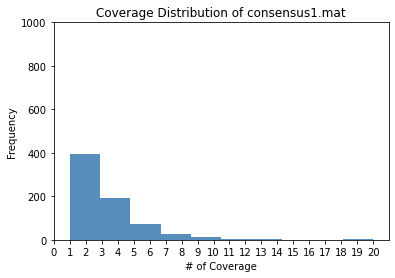

In [7]:
# Get the proportion of low, mid, and high coverages
print(f'Proportion of 1-coverage seqblocks: {coverage_dist[0]/sum(coverage_dist):>12.2%}')
print(f'Proportion of 2-coverage seqblocks: {coverage_dist[1]/sum(coverage_dist):>12.2%}')
print(f'Proportion of [1,2] coverage seqblocks: {(coverage_dist[0]+coverage_dist[1])/sum(coverage_dist):>8.2%}')
print(f'Proportion of [1,2,3] coverage seqblocks: {(coverage_dist[0]+coverage_dist[1]+coverage_dist[2])/sum(coverage_dist):>6.2%}')
print(f'High coverage (6+) Proportion: {sum(coverage_dist[5:len(coverage_dist):1])/sum(coverage_dist):>17.2%}')

# Histogram of the coverage distribution
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (6,4))
ax.set_ylim(0, 1000)
plt.hist(coverage_list, bins=[1,2,3,4,20], align='mid', alpha=0.9, histtype='stepfilled', color='steelblue', edgecolor='none')
ax.set_xticks(range(21))
ax.set_xlabel('# of Coverage')
ax.set_ylabel('Frequency')
ax.set_title('Coverage Distribution of consensus1.mat')

# IDXS are in Python format since enumerate starts at 0
single_coverage_idxs = [i for i, e in enumerate(coverage_list) if e == 1]
double_coverage_idxs = [i for i, e in enumerate(coverage_list) if e == 2]
triple_coverage_idxs = [i for i, e in enumerate(coverage_list) if e == 3]

high_coverage_idxs = [i for i, e in enumerate(coverage_list) if e >= 6]


#### Quality of Low Coverage Reads

#### Read Lengths and Nucleotide Frequency
- IMPORTANT: Are there clusters in our dataset? Do certain indices have bias in certain base calls? Are some more likely than others?

In [23]:
# What if we just looked at the target instead?
start = time.time()
Acount, Ccount, Gcount, Tcount, icount = (0, 0, 0, 0, 0)
for j in range(1, DNA_seqs.size+1):
    unique, count = np.unique(DNA_seqs.get_target(j), return_counts=True)
    if len(unique)==5:
        Acount += unique[-4]
        Ccount += unique[-3]
        Gcount += unique[-2]
        Tcount += unique[-1]
        icount += unique[0]
    elif len(unique) == 4:
        Acount += unique[-4]
        Ccount += unique[-3]
        Gcount += unique[-2]
        Tcount += unique[-1]
    else:
        print(i)
        break
end = time.time()
print(end-start)


110.6504180431366


In [13]:
# Looking at the reads

Acount, Ccount, Gcount, Tcount, icount = (0, 0, 0, 0, 0)
for i in DS:
    reads = DNA_seqs.get_reads(i)
    for j in reads:
        unique, count = np.unique(j, return_counts=True)
        if len(unique)==5:
            Acount += unique[-4]
            Ccount += unique[-3]
            Gcount += unique[-2]
            Tcount += unique[-1]
            icount += unique[0]
        elif len(unique) == 4:
            Acount += unique[-4]
            Ccount += unique[-3]
            Gcount += unique[-2]
            Tcount += unique[-1]
        else:
            print(i)
            break

775
1316
1745
2078
2756
3216
3430
3891
4042
4127
5013
5038
6823
7262
7749
7966
8656
8921
8996
28.120481967926025
34.01426720619202
0 1 2 3 4 5


In [7]:
lens = np.zeros(FILE_SIZE)
true_len = pickle.load(open('pickle/raw_seqlen.pickle', 'rb'))

# for i in (1, FILE_SIZE+1):
#     print)x
    

901

In [9]:
# fudge =[]
# for i in (y.index.to_list()):
#     b, l = DNA_seqs.get_barcode(i)
#     if l == 0: 
#         fudge.append(i)
# fudge[:10]

[7749, 7966, 8996, 17526, 26751, 34232, 35105, 44896, 48012, 49755]

In [17]:
print('{0:d} {1} {2} {3} {4}'.format(Acount, Ccount, Gcount, Tcount, icount))
# Nucleotide Counts
total = Ccount + Tcount + Acount + Gcount + icount
print(f"""
      % A:  {Acount/total:.2f}
      % C:  {Ccount/total:.2f}
      % G:  {Gcount/total:.2f}
      % T:  {Tcount/total:.2f}
      % -:  {icount/total:.2f}
      """)

2023692 2085016 2207664 2606269 997577

      % A:  0.20
      % C:  0.21
      % G:  0.22
      % T:  0.26
      % -:  0.10
      


In [25]:
# Probabiliy dist of reads
# %matplotlib inline
# import matplotlib.pyplot as plt

# seq_len_dist = []
# for i in seqblocks_list:
#     seq_len_dist.append(i.seq_len)

# plt.xlabel("Sequence length")

# plt.ylabel("Frequency")
# plt.title("Prob. Dist. of first 100k sequence blocks")
# plt.hist(seq_len_dist, bins=100, range=(150, 1800), color = 'blue',
#         histtype = 'bar')

In [ ]:

file_name = 'consensus1.mat'
variable_of_interest = 'align3'
h5py_object, data = load_matlab_file(file_name, variable_name=variable_of_interest)

dataset = DNA_SeqBlocks(h5py_object=h5py_object, data=data)

seqblocks_list = []
for i in range(dataset.size+1): #for all 355104 seqblocks, remember that range doesn't include last number and matlab indexing used for get_seqblock
    print(i)
    seqblock_i = dataset.get_seqblock(i) #matlab indexing to allow easy comparison
    cleanseqblock_i = seqblock_parser(seqblock_i) # creates ith CleanSeqBlock
    seqblocks_list.append(cleanseqblock_i) # to house all 355104 CleanSeqBlock(s)
print(len(seqblocks_list))
    
print(f"Total runtime to create 355104 CleanSeqBlock objects: {end-start:.1f} seconds = {(end-start)/60:.0f} minutes.")



In [ ]:
# import pickle

# with open('file.pickle', 'wb') as file_out:
#     pickle.dump(lis, file_out)
    
# x = pickle.load(open('file.pickle','rb'))


## Understanding the meaning of 'z', 'x', and 'y' in dataset
> Key: Absence of quality score use
- **'z'** = failed majority voting btwn reads
- **'x'** = correct/incorrect mutation (majority voted)
- **'yyy'** = indel at non-terminating y's in at least ONE read 


### Testing the meaning of 'z'
- **Confirmed.** 'z' means a disagreement in reads (does not assess respective quality scores)

//TODO:  Resolve most of these conflicts using some architecture. E.g. error pattern from BFP reads to resolve conflicts

### Poor quality 'z' conflicts in double coverage
- About 81 674 seqblocks (~23% of 355104 seqblocks) -> ~10^3 nucleotides/seqblock * 10^4 seqblocks
- 14 978 total conflicts

- 1 765 cases of max Q score != 126 (10^3) => *1/10^4 frequency*
- 166   cases if 73+ is considered conclusive (10^2) => 99.99% accuracy, 1/10^5
- 77    cases if 63+ is considered conclusive (10^1) => 99.9% accuracy, 1/10^6

### Poor quality 'z' conflicts in triple coverage
- About 53 265 seqblocks (~15% of dataset) -> ~10^3 nuc/seqblock * 10^4 seqblocks
- 15 039 total conflicts

- 274  cases of max Q score != 126 (10^2) => *1/10^5 frequency*
- 6     cases of no max Q score 73+ (10^3) => 99.99% accuracy >> 17590, 78157, 119067, 152067, 187907, 189538, 200562, 269346, 315823
- 4     cases of no max Q score 63+ (10^0) => 99.9% accuracy >> 17590, 78157, 152067, 187907, 315823

### Poor quality 'z' conflicts in quadruple coverage
- 18 958 total conflicts

- 90 cases of no max Q score of 126
- 1 case of no max Q score of 73+ >> SB 139087, Nuc 2. Start of reads. Best to guess nonexistent mutation.
- 1 case of no max Q score of 63+

### Further?
- No reason. Clearly shows most conflicts are easily resolved through high accuracy nucleotide reads, especially when coverage >= 3. Concern is how to resolve 2-cov read conflicts at low quality.

In [96]:
tinyDS = range(1, 10_001)
DS = range(1, FILE_SIZE+1)


#### Generates list of chunks (reads + quality) where a z-conflict exists for a SPECIFIED coverage

In [273]:
COV_TEST = 3
CHAR_TEST = ord('z')

test = []
seq = []

for i in DS:
    cov = DNA_seqs.get_coverage_count(i)
    if (cov == COV_TEST):
        seqlen = SEQLEN_LIST[i]
        interp = DNA_seqs.get_interp_changes(i, coverage_count=COV_TEST, true_len=seqlen)
        for npos in range(1,len(interp)+1):
            if interp[npos-1] == CHAR_TEST:
                reads_nuc = DNA_seqs.get_nuc_reads(i,npos,COV_TEST)
                qscores_nuc = DNA_seqs.get_nuc_qscores(i, npos, COV_TEST)
                to_add = np.hstack([reads_nuc,qscores_nuc])
                test.append(to_add)
                seq.append(f'{i}.{npos}')
print(f'Total at {COV_TEST}-cov: {len(test)} \'{chr(CHAR_TEST)}\'conflicts')
print('\n')
cov = COV_TEST

q = [126, 73, 63]

areas = []
results = []
for q_test in q:
    subpar_reads = []
    temp = []
    for i in range(len(test)):
        # if all(x < q_test for x in test[i][slice(cov,2*cov)]):
        curr = test[i]
        _, qscores = np.array_split(curr, 2)
        if qscores.max() < q_test:
            subpar_reads.append(test[i])
            temp.append(seq[i])
    results.append(subpar_reads)
    areas.append(temp)
    print(f'{len(subpar_reads)} where max < {q_test} at {cov} cov')

Total at 3-cov: 15039 'z'conflicts


274 where max < 126 at 3 cov
6 where max < 73 at 3 cov
4 where max < 63 at 3 cov


In [266]:
test, seq, results, areas

(15039, 15039)

#### Deeper Understanding of Z-Conflicts, especially for high quality 126 
- 2/3 are single high-quality
- ~1/3 are two high-quality 
- ~2% are QMAX<126

In [281]:
# Let's first try for triple-cov
# Filter for two types: when 126 at two points yet those two nucleotides differ
# and when 126 at three points yet they don't all agree



# Separate into useable parts

misc = []
easy = []
medium = []
hard = []
# Assesses 
for idx in range(len(test)):
    reads, qscores = np.array_split(test[idx], 2)
    
    
    # Get the indices where quality is 126
    boolindex = qscores == 126
    check = reads[boolindex]
    
    if len(set(check)) == 2: #Means 
        medium.append(seq[idx])
        # print(f'{len(check)} high quality reads. 2 options. {seq[idx]}')
    elif (len(set(check)) == 3):
        hard.append(seq[idx])
    elif (len(set(check)) == 1):
        easy.append(seq[idx])
    else: misc.append(seq[idx])
len(easy), len(medium), len(hard), len(easy)+len(medium)+len(hard), len(misc)
        
    
    

(10367, 4398, 0, 14765, 274)

In [255]:
test[130]

array([ 45,  67,  71,  33, 122,  76], dtype=uint16)

In [99]:
COV_TEST=1
CHAR_TEST='x' # only x for this cell

test = [] 
seq = []

for i in totalDS: #whole 
    cov = DNA_seqs.get_coverage_count(i)
    if (cov == COV_TEST):  # Only care about a specific coverage
        interp = DNA_seqs.get_interp_mutations(i, COV_TEST) # Now we're looking at the interp changes... eventually searching for 'z'
        for npos in range(len(interp)):
            if interp[npos] == ord(CHAR_TEST): #Oh dang there's the char at this npos... let's add an array showing the nuc reads and quality along with the z char for security (1x1+2*cov)
                reads = DNA_seqs.get_nuc(i, COV_TEST, npos)
                quality = DNA_seqs.get_quality(i, COV_TEST, npos)
                to_add = np.hstack([reads,quality])
                if quality.max() != 126:
                    # print(f"Debug: {quality.max()} and sequence {i}, nucleotide {npos}")
                    test.append(to_add)
                    seq.append(i)
len(test)



405665

## TEST: Visually representing a set of DNA Reads

In [210]:
from fastai.vision.all import *
from fastai import *

test = DNA_seqs.get_reads(547)
print(test[0][0:10])
vector = torch.zeros([5,SEQLEN_LIST[547]])
encoding = ['A', 'C', 'G', 'T', '-']
for r in test:
    for n in range(len(test[0])):
        i = r[n]
        if i == 65:
            vector[0, n] = 1
        elif i == 67:
            vector[1, n] = 1
        elif i == 71:
            vector[2, n] = 1
        elif i == 84:
            vector[3, n] = 1
        else:
            vector[4, n] = 1
            
# Attempt to encode the reads as an image            
import pandas as pd
df = pd.DataFrame(vector)
df.style.set_properties(**{'font-size':'1pt'}).background_gradient('Greys')


[67 84 65 71 67 71 67 84 65 67]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433


In [227]:
def find_npos(no, char='z'):
    """Finds the nth nucleotides with a 'z'

    Args:
        no (int): which seqblock?

    Returns:
        int: nth nucleotide (MATLAB indexing)
    """
    results = []
    n = DNA_seqs.get_interp_changes(no)
    for i in range(len(n)):
        if n[i] == ord(char):
            results.append(i+1)
    return results
find_npos(547)

[1047]

In [101]:
len(test)
cov = 1

q_test = 73
 
areas = []
for i in range(len(test)):
    if (test[i][slice(cov,2*cov)].max() < q_test): areas.append(seq[i])

subpar_reads = [test[i] for i in range(len(test)) if all(x < q_test for x in test[i][slice(cov,2*cov)])]
# subpar_reads = [test[i] for i in range(len(test)) if test[i][3] < q_test and test[i][2] < q_test]
len(subpar_reads), subpar_reads, areas[0:5]

(159856,
 [array([67, 38], dtype=uint16),
  array([84, 36], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([65, 68], dtype=uint16),
  array([65, 57], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([67, 47], dtype=uint16),
  array([65, 51], dtype=uint16),
  array([71, 56], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([71, 71], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([71, 42], dtype=uint16),
  array([65, 45], dtype=uint16),
  array([67, 51], dtype=uint16),
  array([67, 61], dtype=uint16),
  array([67, 49], dtype=uint16),
  array([84, 40], dtype=uint16),
  array([84, 51], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([45, 33], dtype=uint16),
  array([45, 33], dtype=uint16),
 

In [68]:
# I want to test the get_nuc and get_quality funcs
nuc_test=1
sb_test=47

true = seqblock_parser(DNA_seqs.get_seqblock(sb_test))

cov = DNA_seqs.get_coverage_count(sb_test)
reads= DNA_seqs.get_nuc_reads(sb_test, cov, nuc_test)
quality = DNA_seqs.get_nuc_qscores(sb_test, cov, nuc_test)
reads, quality, cov


(array([84, 84], dtype=uint16), array([126, 126], dtype=uint16), 2)

In [90]:
ord('A'),ord('C'),ord('G'),ord('T'), ord('-'), ord('!')

(65, 67, 71, 84, 45, 33)